### Evaluation and plots of results

In [ ]:
# !pip install transformers -U
# !pip install datasets

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
models_path = '/content/drive/MyDrive/Colab Notebooks/nlp_unicamp/final_project/models/'

models_names = ['infini_50percent_1epoch', 'selfattn_50percent_1epoch']

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer

# Infini 50% data with 1 epoch
model_infini = GPT2LMHeadModel.from_pretrained(models_path + models_names[0]).to(device)
tokenizer_infini = GPT2Tokenizer.from_pretrained(models_path + models_names[0])

# Self-Attention 50% data with 1 epoch
model_selfatt = GPT2LMHeadModel.from_pretrained(models_path + models_names[1]).to(device)
tokenizer_selfatt = GPT2Tokenizer.from_pretrained(models_path + models_names[1], add_prefix_space=True, add_bos_token=True)

# Generation setup
model_infini.generation_config.pad_token_id = tokenizer_infini.pad_token_id
model_selfatt.generation_config.pad_token_id = tokenizer_self_att.pad_token_id

Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp_unicamp/final_project/models/infini_50percent_1epoch were not used when initializing GPT2LMHeadModel: ['transformer.h.0.attn.causal', 'transformer.h.1.attn.causal', 'transformer.h.10.attn.causal', 'transformer.h.11.attn.causal', 'transformer.h.2.attn.causal', 'transformer.h.3.attn.causal', 'transformer.h.4.attn.causal', 'transformer.h.5.attn.causal', 'transformer.h.6.attn.causal', 'transformer.h.7.attn.causal', 'transformer.h.8.attn.causal', 'transformer.h.9.attn.causal']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

In [ ]:
# Playground Generate
input_ids = tokenizer_self_att("As praias", return_tensors="pt", truncation=True)
attention_mask = input_ids.attention_mask.to(device)
input_ids = input_ids.input_ids.to(device)

generation = model_selfatt.generate(input_ids, do_sample=True, max_new_tokens=50, attention_mask=attention_mask, temperature = 1, eos_token_id=tokenizer.convert_tokens_to_ids('.'))
print(tokenizer_self_att.decode(generation[0], skip_special_tokens=True))

 As praias do sul, e São José do Rio de Janeiro.


### Load dataset

In [ ]:
from datasets import Dataset
import torch

path_dataset = '/content/drive/MyDrive/Colab Notebooks/nlp_unicamp/final_project/tokenizer/datasets/split_10/'

train_dataset = Dataset.load_from_disk(path_dataset + "train_dataset")
test_dataset = Dataset.load_from_disk(path_dataset + "test_dataset")

# 50% train data and 5% of test data of 50% train data.
train_dataset = train_dataset.select(range(int(len(train_dataset))))
test_dataset = test_dataset.select(range(4 * 16)) # 6 * 16

In [ ]:
def generate_from_ds(model, tokenizer, ds, idx, n_tokens):
    """
    Generate text from a given dataset of input_ids and attention_mask.
    model: GPT2LMHeadModel
    tokenizer: GPT2Tokenizer
    ds: Dataset
    idx: int
    n_tokens: int
    """

    # Index
    sample = 0
    n_tokens = 10
    # Load from trainset
    input_ids = ds['input_ids'][idx].unsqueeze(0).to(device)
    print('complete original text: ', tokenizer.batch_decode(input_ids, skip_special_tokens=True)[0])
    input_ids = input_ids[:, :n_tokens]

    attention_mask = ds['attention_mask'][idx][:n_tokens].unsqueeze(0).to(device)

    print('split original text: ',tokenizer.batch_decode(input_ids, skip_special_tokens=True)[0])


    generation = model.generate(
        input_ids,
        do_sample=True,
        max_new_tokens=50,
        attention_mask=attention_mask,
        temperature=1,  # Increased temperature for more variety
        top_k=100,  # Using Top-K sampling
        top_p=0.8,  # Using nucleus sampling
        repetition_penalty=1,  # Applying repetition penalty
        no_repeat_ngram_size=10,  # Preventing repeating ngrams within generated tokens
        # eos_token_id=tokenizer.convert_tokens_to_ids('.')
    )
    print('generated text: ', tokenizer.decode(generation[0], skip_special_tokens=True))

In [ ]:
generate_from_ds(model_selfatt, tokenizer_selfatt, train_dataset, 5, 10)

complete original text:   deputado ao Conselho dos Quinhentos em representação da Córsega. Presidia ao conselho no dia 18 do Brumário, tendo conspirado activamente com Emmanuel Joseph Sieyès na preparação do golpe de Estado daquele dia. Apesar disso, pouco se beneficia dos seus resultados. Ocupou o lugar de Ministro do Interior da França, durante o Consulado, a partir de 24 de Dezembro de 1799, substituindo no cargo a Pierre Simon de Laplace. Logo no ano seguinte, aparentemente por fazer sombra ao seu irmão Napoleão, o Primeiro Cônsul, foi sucedido no ministério por Jean Antoine Chaptal, sendo enviado para Madrid como embaixador. Durante o ano em que permaneceu em Madrid conseguiu fazer prevalecer a influência francesa contra a britânica, obtendo assim as boas graças do irmão Napoleão, apesar de ter envolvido em negócios pouco claros com os governos espanhol e português. Durante a sua estadia em Madrid fez-se grande amigo de Manuel Godoy, o "Príncipe da Paz", estando a sua acção conjun

In [ ]:
generate_from_ds(model_infini, tokenizer_infini, train_dataset, 5, 10)

complete original text:   deputado ao Conselho dos Quinhentos em representação da Córsega. Presidia ao conselho no dia 18 do Brumário, tendo conspirado activamente com Emmanuel Joseph Sieyès na preparação do golpe de Estado daquele dia. Apesar disso, pouco se beneficia dos seus resultados. Ocupou o lugar de Ministro do Interior da França, durante o Consulado, a partir de 24 de Dezembro de 1799, substituindo no cargo a Pierre Simon de Laplace. Logo no ano seguinte, aparentemente por fazer sombra ao seu irmão Napoleão, o Primeiro Cônsul, foi sucedido no ministério por Jean Antoine Chaptal, sendo enviado para Madrid como embaixador. Durante o ano em que permaneceu em Madrid conseguiu fazer prevalecer a influência francesa contra a britânica, obtendo assim as boas graças do irmão Napoleão, apesar de ter envolvido em negócios pouco claros com os governos espanhol e português. Durante a sua estadia em Madrid fez-se grande amigo de Manuel Godoy, o "Príncipe da Paz", estando a sua acção conjun

### Load CSV Logs

In [ ]:
import pandas as pd
import numpy as np

infini_10percent_5epoch_logs = pd.read_csv('infini_10percent_5epoch.csv')[1:]
infini_50percent_1epoch_logs = pd.read_csv('infini_50percent_1epoch.csv')[1:]
selfattn_50percent_1epoch_logs = pd.read_csv('selfattn_50percent_1epoch.csv')

# as float each column
infini_10percent_5epoch_logs = infini_10percent_5epoch_logs.astype(float)
infini_50percent_1epoch_logs = infini_50percent_1epoch_logs.astype(float)

# Normalize
infini_50percent_1epoch_logs['Step'] /= infini_50percent_1epoch_logs['Step'].max()
infini_10percent_5epoch_logs['Step'] /= infini_10percent_5epoch_logs['Step'].max() / 5
selfattn_50percent_1epoch_logs['Step'] /= selfattn_50percent_1epoch_logs['Step'].max()

# Train Perplexity
infini_10percent_5epoch_logs['Train Perplexity'] = np.exp(infini_10percent_5epoch_logs['Training Loss'])
infini_50percent_1epoch_logs['Train Perplexity'] = np.exp(infini_50percent_1epoch_logs['Training Loss'])
selfattn_50percent_1epoch_logs['Train Perplexity'] = np.exp(selfattn_50percent_1epoch_logs['Training Loss'])

# Validation Perplexity
infini_10percent_5epoch_logs['Validation Perplexity'] = np.exp(infini_10percent_5epoch_logs['Validation Loss'])
infini_50percent_1epoch_logs['Validation Perplexity'] = np.exp(infini_50percent_1epoch_logs['Validation Loss'])
selfattn_50percent_1epoch_logs['Validation Perplexity'] = np.exp(selfattn_50percent_1epoch_logs['Validation Loss'])

# Setup PPL
initial_step = selfattn_50percent_1epoch_logs['Step'].iloc[0]

# filter infini_50percent_1epoch_logs with step > initial_step
initial_step_infini = infini_50percent_1epoch_logs[infini_50percent_1epoch_logs['Step'] > initial_step]

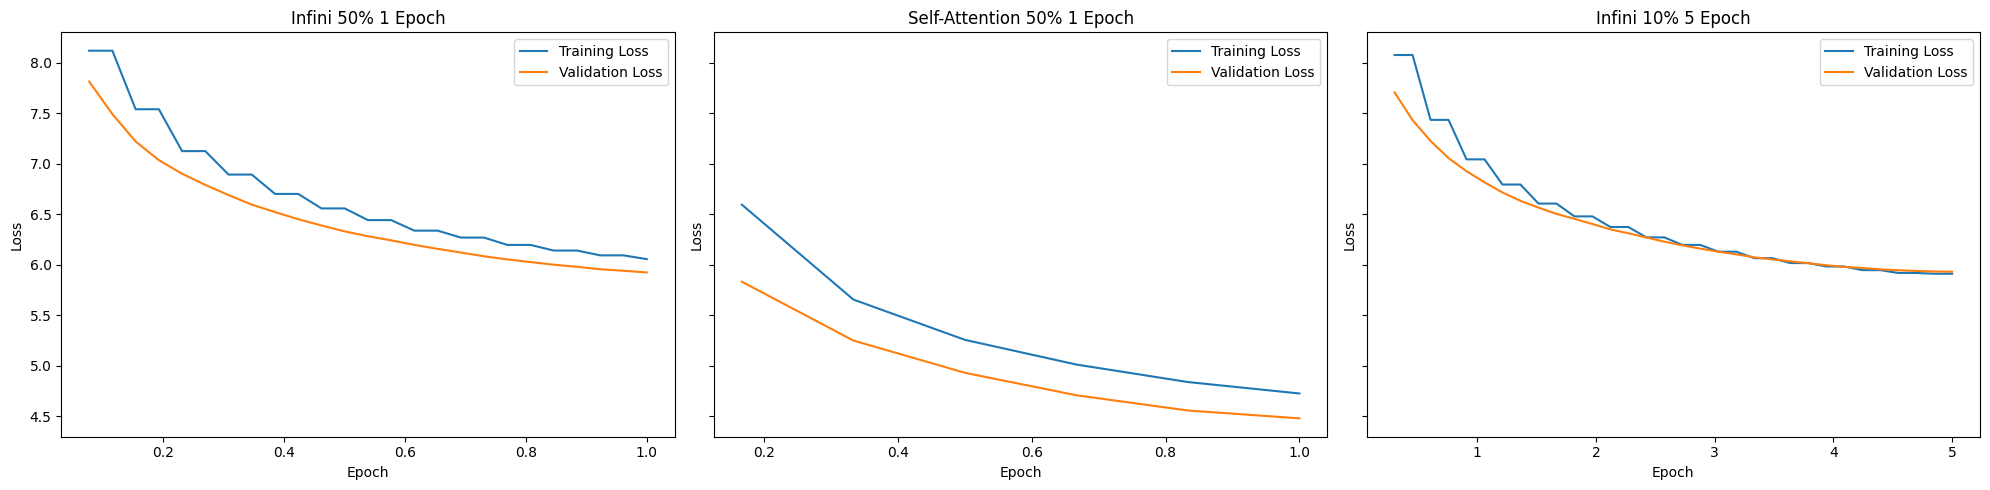

In [ ]:
import matplotlib.pyplot as plt

# Setting up the figure and axes for a 3-row plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

# Plot for infini_50percent_1epoch_logs
axs[0].plot(infini_50percent_1epoch_logs['Step'], infini_50percent_1epoch_logs['Training Loss'], label='Training Loss')
axs[0].plot(infini_50percent_1epoch_logs['Step'], infini_50percent_1epoch_logs['Validation Loss'], label='Validation Loss')
axs[0].set_title('Infini 50% 1 Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot for selfattn_50percent_1epoch_logs
axs[1].plot(selfattn_50percent_1epoch_logs['Step'], selfattn_50percent_1epoch_logs['Training Loss'], label='Training Loss')
axs[1].plot(selfattn_50percent_1epoch_logs['Step'], selfattn_50percent_1epoch_logs['Validation Loss'], label='Validation Loss')
axs[1].set_title('Self-Attention 50% 1 Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# # Plot for infini_10percent_5epoch_logs
axs[2].plot(infini_10percent_5epoch_logs['Step'], infini_10percent_5epoch_logs['Training Loss'], label='Training Loss')
axs[2].plot(infini_10percent_5epoch_logs['Step'], infini_10percent_5epoch_logs['Validation Loss'], label='Validation Loss')
axs[2].set_title('Infini 10% 5 Epoch')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()

plt.tight_layout()

# plt.savefig('infini_self.png')
plt.show()



In [ ]:
def extract_initial_final(data):
    initial = data.iloc[0]
    final = data.iloc[-1]
    return {
        'First Training Perplexity (~16% epoch)': initial['Train Perplexity'],
        'Final Training Perplexity': final['Train Perplexity'],
        'First Validation Perplexity (~16% epoch)': initial['Validation Perplexity'],
        'Final Validation Perplexity': final['Validation Perplexity']
    }

# Extract values for each dataset
# infini_10percent_5epoch_metrics = extract_initial_final(infini_10percent_5epoch_logs)
infini_50percent_1epoch_metrics = extract_initial_final(initial_step_infini)
selfattn_50percent_1epoch_metrics = extract_initial_final(selfattn_50percent_1epoch_logs)

# Create a DataFrame from the extracted values
summary_df = pd.DataFrame({
    # 'Infini 10% 5 Epochs': infini_10percent_5epoch_metrics,
    'Infini 50% 1 Epoch': infini_50percent_1epoch_metrics,
    'Self-Attention 50% 1 Epoch': selfattn_50percent_1epoch_metrics
})

summary_df

,Infini 50% 1 Epoch,Self-Attention 50% 1 Epoch
First Training Perplexity (~16% epoch),1883.336092,732.160681
Final Training Perplexity,427.134948,112.956185
First Validation Perplexity (~16% epoch),1137.952643,341.489523
Final Validation Perplexity,374.421063,88.322422
